# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
import platform
import os

# Checking platform/machine
print('Current platform: {}-{}'.format(platform.system(), platform.machine()))
unity_env_folder = 'unity_envs'
env_name = 'Tennis'
# Since I am switching between platforms
unity_env_file_name = {'Linux-x86_64': os.path.join(unity_env_folder, env_name, 'Tennis_Linux', 'Tennis.x86_64'),
                       'Darwin-x86_64': os.path.join(unity_env_folder, env_name, 'Tennis_Darwin', 'Tennis.app')}['{}-{}'.format(platform.system(), platform.machine())]

Current platform: Linux-x86_64


In [3]:
env = UnityEnvironment(file_name=unity_env_file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
# for i in range(1, 50):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. Exploring DDPG Agents

We are exploring here 2 DDPG agents that share the Critic neural network (model) and use 2 (disjoint) Actors trained simultaniously using/sampling from the same uniform experience replay buffer.

As part of the next cell output we summarize the Architecture of the shared critic and the 2 competing/collaborating Actors.


In [8]:
from ddpg_agent import DDPGAgent, LocalTarget
from replay_buffer import PrioritizedReplayBufferFactory, UniformReplayBufferFactory
from q_net import ActorFCNetFactory, CriticFCNetFactory

def extract_state(env_info) -> np.ndarray:
    """ state extractor: extracts state representation from env_info"""
    return env_info.vector_observations

replay_buffer_factory = UniformReplayBufferFactory()
actor_factory = ActorFCNetFactory(state_size, action_size, layers=(128, 64))
critic_factory = CriticFCNetFactory(state_size, action_size,  state_rep_layers = (64,) , critic_layers = (64, 64, 32))

explorer = DDPGAgent(actor_factory, critic_factory, replay_buffer_factory, actors_nbr=num_agents,
                          seed=0, step_to_update=2, buffer_size=int(1e4), batch_size=256, name='ddpg exploration', gamma=.999, lr_actor=2e-4, lr_critic=5e-4)
explorer.explore(env, extract_state, n_episodes=3000, max_t=1000, solved_score=0.5)

INFO:root:Building replay buffer with size 10000


Critic.local check: CriticFCNet(
  (state_rep_layers): ModuleList(
    (0): Linear(in_features=24, out_features=64, bias=True)
  )
  (critic_layers): ModuleList(
    (0): Linear(in_features=66, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
ActorFCNet(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (batch_norm): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
ActorFCNet(
  (layers): ModuleList(
    (0): Linear(in_features=24, out

In [9]:
def ma(scores, window):
    """ Moving average helper (for result plotting)"""
    tmp = np.cumsum(scores)
    return (tmp[window:] - tmp[:-window])/window

def plot_scores(agents, episodes_window=100):
    """ A helper to plot scores."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for agent in agents:
        scores = ma (agent.scores, episodes_window)
        plt.plot(np.arange(episodes_window, episodes_window + len(scores)), scores, label=agent.name) 

    # plt.yticks (range(30))
    plt.ylabel('Score av. window [{}]'.format(episodes_window))
    plt.xlabel('Episode #')
    plt.legend()
    plt.grid()
    plt.show()

The graphic illustrate that the agents get an average score of +0.5 (over 100 consecutive episodes, after taking the average over both agents : which is a lower bound of max over both agent).

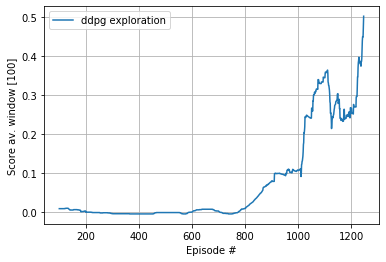

In [10]:
plot_scores([explorer], 100)

In [11]:
# Saving Actor and critic models
import torch
torch.save(explorer.critic.local.state_dict(), '{}.chpnt.pth'.format('tennis_ddpg_critic'))
for index, actor in enumerate(explorer.actors):
        torch.save(explorer.critic.local.state_dict(), '{}_{}.chpnt.pth'.format('tennis_ddpg_actor', index))

### 5. Future ideas/improvement

With the proposed solutions outputs 2 agents (from the actor perspective). As an alternative to be tested we might also think about sharing the Actor model between "agents", letting it acting for both players and study the stability.

A second extension wich might be done after that is to maintain/exploit a pool of Actors and Critics wchich are simultaniously trained (with different samples from the replay buffer) and sampled for chosing both player actions. And study the stability of such a configuration


### 6. Closing env.
When finished, you can close the environment.

In [13]:
env.close()